In [22]:
#@title ***Importing required librarys***

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense,Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error, mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title ***Loading the dataset***

data = pd.read_csv("/content/drive/MyDrive/ProjectCOMP703/file.csv")
data = data.drop([data.columns[0]], axis=1)
data.values[:5].tolist()

[['ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI',
  'neutral'],
 ['Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr',
  'good'],
 ['ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\\n\\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34',
  'neutral'],
 ['THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71',
  'good'],
 ['As of 2 minutes ago, @OpenAI released their new ChatGPT. \\n\\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1',
  'bad']]

# Drop duplicated values

In [5]:
print("Duplicated values: " , data.duplicated().sum())

data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

Duplicated values:  1671
<class 'pandas.core.frame.DataFrame'>
Int64Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


# balance data

In [6]:
data["labels"].value_counts()

bad        106695
good        55754
neutral     55174
Name: labels, dtype: int64

In [7]:
class_0 = data[data["labels"] == "neutral"]
class_1 = data[data["labels"] == "good"]
class_neg = data[data["labels"] == "bad"]
class_neg  = class_neg.iloc[:70000]
data = pd.concat([class_neg , class_0 , class_1])

data.head()

,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
6,"As of 2 minutes ago, @OpenAI released their ne...",bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,bad
17,#ai Models are set to become the search engine...,bad
39,Google is done.\n\nCompare the quality of thes...,bad


In [8]:
data["labels"].value_counts()

bad        70000
good       55754
neutral    55174
Name: labels, dtype: int64

In [29]:
labels = data['labels'].value_counts()
numbers = labels.index
quantity = labels.values

In [30]:
import plotly.express as px 
figure = px.pie(data, values = quantity,  names =  numbers, hole = 0.5)
figure.show()

# cleaning dataset

In [11]:
#@title ***Cleaning the dataset***
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False
    
    return True

def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    #words = [st.stem(word) for word in words]
    words = [lem.lemmatize(word) for word in words]
    
    # text = " ".join([word for word in text.split(" ") if is_alpha(word)])
    # text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A) 
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)
    
    return text.strip()

data.insert(len(data.columns)-1, "cleaned_tweets", data['tweets'].apply(clean_dataset))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweets,cleaned_tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,bad
17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,bad
39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,bad


# converting dataset in numerical form

In [12]:
from numpy.core import numeric
#@title ***Converting text to numerical form***

import math
import collections

def convert_text_to_numerical(text):
    num_words = 7000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
 
    #maxlen = max(45, math.ceil(np.average([len(seq) for seq in sequences])))
    maxlen = 140
    
 
    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    pad_seqs_todrop = []
    for i, p in enumerate(pad_seqs):
        if sum(p) == sum(sorted(p, reverse=True)[0:2]):
            pad_seqs_todrop.append(i)

    return pad_seqs, pad_seqs_todrop, tokenizer, num_words, maxlen

data = data.reset_index()
numeric_tweets, rows_todrop, tokenizer, num_words, maxlen = convert_text_to_numerical(data['cleaned_tweets'])
data.insert(len(data.columns)-1, "numeric_tweets", numeric_tweets.tolist())
data.head()

,index,tweets,cleaned_tweets,numeric_tweets,labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad


In [13]:
#@title ***Encoding output labels***

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['labels']))
print(label_encoder.classes_)
data.head()

['bad' 'good' 'neutral']


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


In [14]:
final_data = data.drop(rows_todrop, inplace=False)
print(len(data), len(final_data))
final_data.head()

180928 167734


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


# Splitting Data: taining 80% and 20% for testing

In [15]:
#@title ***Splitting the dataset into training and testing sets***
inputs = final_data[['tweets', 'cleaned_tweets', 'numeric_tweets']]
outputs = final_data[['labels', 'encoded_labels']]

in_train, in_test, out_train, out_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = in_train['numeric_tweets']
X_test = in_test['numeric_tweets'] 
y_train = out_train['encoded_labels']
y_test = out_test['encoded_labels']

# Saving training and testing data into csv files

In [ ]:
#training_df = pd.concat([in_train, out_train], axis=1)
#training_df.to_csv('training_data.csv', encoding='utf-8', index=False)
#testing_df = pd.concat([in_test, out_test], axis=1)
#testing_df.to_csv('testing_data.csv', encoding='utf-8', index=False)

In [16]:
X_train = np.asarray(X_train.tolist())
X_train = X_train.astype(np.int32)
X_test = np.asarray(X_test.tolist()).astype(np.int32)
y_train = np.asarray(y_train.tolist()).astype(np.int32)
y_test = np.asarray(y_test.tolist()).astype(np.int32)
type(X_train)

numpy.ndarray

In [17]:
X_train

array([[   0,    0,    0, ...,  618,  106,  407],
       [   0,    0,    0, ...,   46,    2, 2489],
       [   0,    0,    0, ...,  949, 5749,   31],
       ...,
       [   0,    0,    0, ...,  104,  314,  178],
       [   0,    0,    0, ..., 1108, 1815,   20],
       [   0,    0,    0, ...,  195,  479,   46]], dtype=int32)

# Cnn training

In [18]:
#@title ***Building the CNN model***
from keras.callbacks import EarlyStopping
model1 = Sequential()
model1.add(Embedding(input_dim=num_words,output_dim=128, input_length=maxlen , trainable = True))

model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)])


Epoch 1/10
118/118 [==============================] - 46s 287ms/step - loss: 0.7284 - accuracy: 0.6733 - val_loss: 0.4596 - val_accuracy: 0.8248
Epoch 2/10
118/118 [==============================] - 14s 121ms/step - loss: 0.3824 - accuracy: 0.8719 - val_loss: 0.3648 - val_accuracy: 0.8817
Epoch 3/10
118/118 [==============================] - 11s 92ms/step - loss: 0.3155 - accuracy: 0.9007 - val_loss: 0.3417 - val_accuracy: 0.8875
Epoch 4/10
118/118 [==============================] - 8s 66ms/step - loss: 0.2778 - accuracy: 0.9150 - val_loss: 0.3436 - val_accuracy: 0.8887
Epoch 5/10
118/118 [==============================] - 6s 55ms/step - loss: 0.2438 - accuracy: 0.9271 - val_loss: 0.3563 - val_accuracy: 0.8815
Epoch 6/10
118/118 [==============================] - 3s 24ms/step - loss: 0.2092 - accuracy: 0.9388 - val_loss: 0.3758 - val_accuracy: 0.8789


# Cnn testing : 87

In [20]:
predicted_labels = model1.predict(X_test, verbose=1)

1049/1049 [==============================] - 2s 2ms/step


In [23]:
def get_measurements(true_y, pred_y, average='macro'):
    accuracy = accuracy_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y, average=average)
    precision = precision_score(true_y, pred_y, average=average)
    fscore = f1_score(true_y, pred_y, average=average)
    mse = mean_squared_error(true_y, pred_y)  # Calculate MSE
    #auc_roc = roc_auc_score(true_y, pred_y, multi_class='ovr' )  # Calculate AUC-ROC
    mae = mean_absolute_error(true_y, pred_y)  # Calculate MAE

    measurements = {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "fscore": fscore,
        "mse": mse,
        
        "mae": mae
    }

    return measurements

    

values= get_measurements(y_test, np.argmax(predicted_labels, axis=1))
print(values)


{'accuracy': 0.8791844278176886, 'recall': 0.8783714262157626, 'precision': 0.8791594780966187, 'fscore': 0.878399590125014, 'mse': 0.2782066950845083, 'mae': 0.17327927981637703}


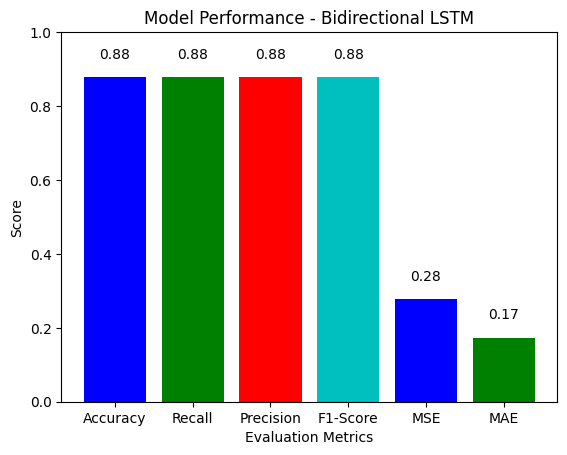

In [25]:
import matplotlib.pyplot as plt
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-Score','MSE','MAE']
scores = [values["accuracy"],values["recall"], values["precision"], values["fscore"],values["mse"],values["mae"]]
colors = ['b', 'g', 'r', 'c']
plt.bar(metrics, scores, color=colors)

# Add labels and title
plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Model Performance - Bidirectional LSTM')

# Set the y-axis limit to be between 0 and 1
plt.ylim([0, 1])

# Add text labels to each bar
for i in range(len(metrics)):
    plt.text(x=i, y=scores[i]+0.05, s=np.round(scores[i], 2), ha='center')

# Display the chart
plt.show()

# Cnn prediction

In [26]:
def predict_user_input(tweets , model):
    data = pd.DataFrame({ 'Tweets': tweets })
    cleaned_data = data['Tweets'].apply(clean_dataset)
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    predicted_labels = model.predict(pad_seqs)
    data['labels'] = [ label_encoder.classes_[label_num] for label_num in np.argmax(predicted_labels, axis=1)]
    #print(data)
    return predicted_labels, data 


predict_user_input([
    'chatgpt is very crazy !', 
    'chatgpt is kind a dangerous', 
    'woooow, chatgt is really impressive !!!',
    "chatgpt is an AI tool",
    "good results"] , model1)

predict_user_input([
    "The worst result, I did not expect that unwanted results. it is a useless tool",
    "my name is ahmed i want to became a data scientist",
    'woooow, chatgt is really impressive i can not imagine how chatgpt generate solution like humans  ',
    "chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it",
    "good results when i use this tool i like it and it helped me and better than google"
] , model1)



1/1 [==============================] - 0s 22ms/step


(array([[9.99715626e-01, 2.10110866e-05, 2.63337715e-04],
        [1.07928410e-01, 5.95144136e-03, 8.86120141e-01],
        [4.55436937e-04, 9.99456227e-01, 8.82735549e-05],
        [9.23149381e-03, 8.84826660e-01, 1.05941854e-01],
        [1.79169321e-04, 9.99145746e-01, 6.75135059e-04]], dtype=float32),
                                               Tweets   labels
 0  The worst result, I did not expect that unwant...      bad
 1  my name is ahmed i want to became a data scien...  neutral
 2  woooow, chatgt is really impressive i can not ...     good
 3  chatgpt is an AI helpful tool to help solve co...     good
 4  good results when i use this tool i like it an...     good)

In [27]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


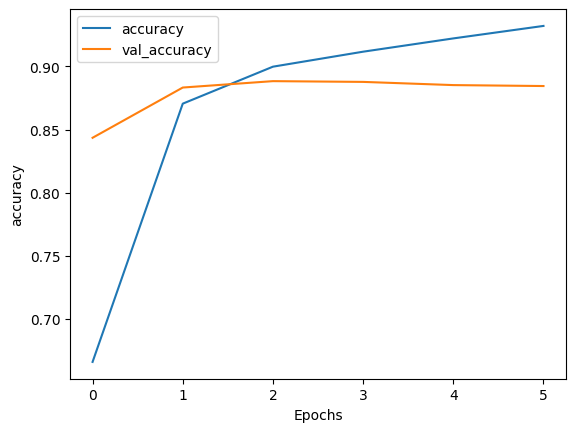

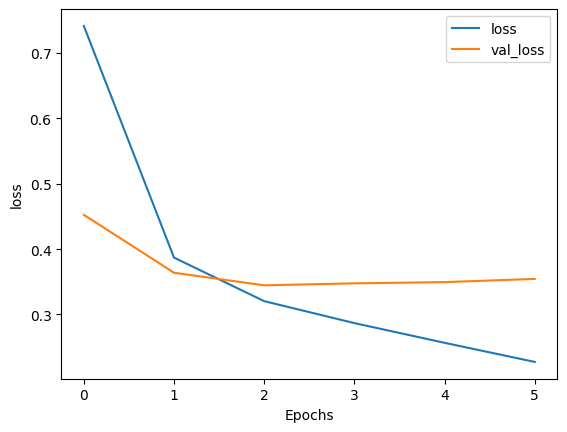

In [ ]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

In [28]:
def userIn(mo):
    x=input("enter sentence or x for exit: ")
    while x != "x":
        print(predict_user_input([x] , mo))
        x=input("enter sentence or x for exit: ")
        
userIn(model1)

enter sentence or x for exit: Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it.
1/1 [==============================] - 0s 100ms/step
(array([[0.0016311 , 0.99637896, 0.00198998]], dtype=float32),                                               Tweets labels
0  Try talking with ChatGPT, our new AI system wh...   good)
enter sentence or x for exit: x
